In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_log_error




In [4]:
# Base path to your data folder 
base_path = "/Users/machome/Downloads/store-sales-time-series-forecasting/"

# Load datasets 
train = pd.read_csv(base_path + "train.csv", parse_dates=["date"])
test = pd.read_csv(base_path + "test.csv", parse_dates=["date"])
stores = pd.read_csv(base_path + "stores.csv")
oil = pd.read_csv(base_path + "oil.csv", parse_dates=["date"])
holidays = pd.read_csv(base_path + "holidays_events.csv", parse_dates=["date"])
transactions = pd.read_csv(base_path + "transactions.csv", parse_dates=["date"])


In [5]:
# Quick look at each dataset
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)
print("Oil shape:", oil.shape)
print("Holidays shape:", holidays.shape)
print("Transactions shape:", transactions.shape)

train.head()

Train shape: (3000888, 6)
Test shape: (28512, 5)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Holidays shape: (350, 6)
Transactions shape: (83488, 3)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
# Function to display missing values summary for a dataframe
def missing_summary(df, name):
    print(f"\nMissing values in {name}:")
    missing = df.isna().sum()
    missing = missing[missing > 0]
    if len(missing) == 0:
        print("  No missing values.")
    else:
        print(missing)

# Check each dataset
missing_summary(train, "train")
missing_summary(test, "test")
missing_summary(stores, "stores")
missing_summary(oil, "oil")
missing_summary(holidays, "holidays")
missing_summary(transactions, "transactions")



Missing values in train:
  No missing values.

Missing values in test:
  No missing values.

Missing values in stores:
  No missing values.

Missing values in oil:
dcoilwtico    43
dtype: int64

Missing values in holidays:
  No missing values.

Missing values in transactions:
  No missing values.


In [18]:
# Aggregate total sales per day across all stores and families
daily_sales = (
    train.groupby("date")["sales"]
    .sum()
    .reset_index()
    .set_index("date")
    .asfreq("D")
)

daily_sales.head()

# Confirm there are no missing values in the aggregated series
daily_sales.isna().sum()


sales    4
dtype: int64

In [19]:
# fill any missing dates with 0 sales
daily_sales["sales"] = daily_sales["sales"].fillna(0)

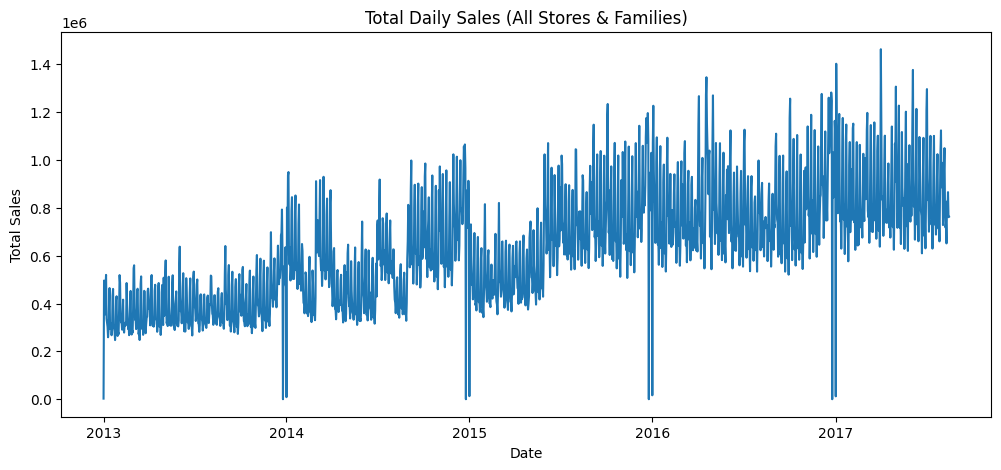

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales["sales"])
plt.title("Total Daily Sales (All Stores & Families)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


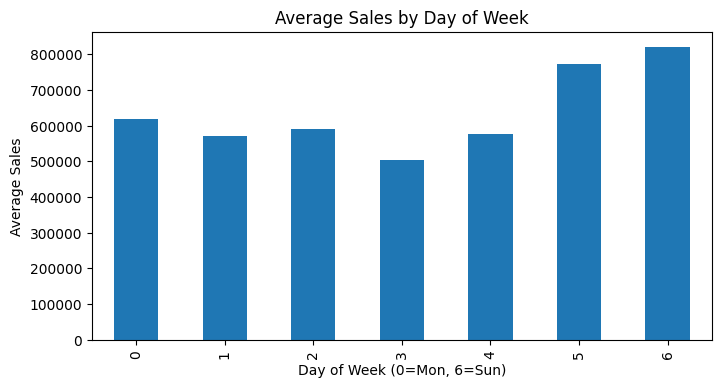

In [22]:
# Add day of week (0 = Monday, 6 = Sunday)
daily_sales["dow"] = daily_sales.index.dayofweek

avg_by_dow = daily_sales.groupby("dow")["sales"].mean()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
avg_by_dow.plot(kind="bar")
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Average Sales")
plt.show()


In [25]:
# Split the time series into training and validation sets (time-based split)

# Use the last 56 days (8 weeks) for validation to cover multiple weekly cycles
horizon = 56


train_ts = daily_sales.iloc[:-horizon]
val_ts = daily_sales.iloc[-horizon:]

print("Train period:", train_ts.index.min(), "to", train_ts.index.max())
print("Validation period:", val_ts.index.min(), "to", val_ts.index.max())


Train period: 2013-01-01 00:00:00 to 2017-06-20 00:00:00
Validation period: 2017-06-21 00:00:00 to 2017-08-15 00:00:00


In [28]:
# Fit ETS model with additive trend and weekly seasonality
ets_model = ExponentialSmoothing(
    train_ts["sales"],
    trend="add",
    seasonal="add",
    seasonal_periods=7
).fit()

print(ets_model.summary())


/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: divide by zero encountered in matmul
  return err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: invalid value encountered in matmul
  return err.T @ err


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                 1632
Model:             ExponentialSmoothing   SSE                 18460425149183.746
Optimized:                         True   AIC                          37801.313
Trend:                         Additive   BIC                          37860.686
Seasonal:                      Additive   AICC                         37801.538
Seasonal Periods:                     7   Date:                 Wed, 11 Feb 2026
Box-Cox:                          False   Time:                         19:34:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2373835                alpha                 True
smoothing_trend          

/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err


In [29]:
# Forecast the validation period
ets_forecast = ets_model.forecast(len(val_ts))

# Quick look at the first few forecast values
ets_forecast.head()


/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err


2017-06-21    8.088882e+05
2017-06-22    6.820936e+05
2017-06-23    8.051733e+05
2017-06-24    1.024301e+06
2017-06-25    1.057004e+06
Freq: D, dtype: float64

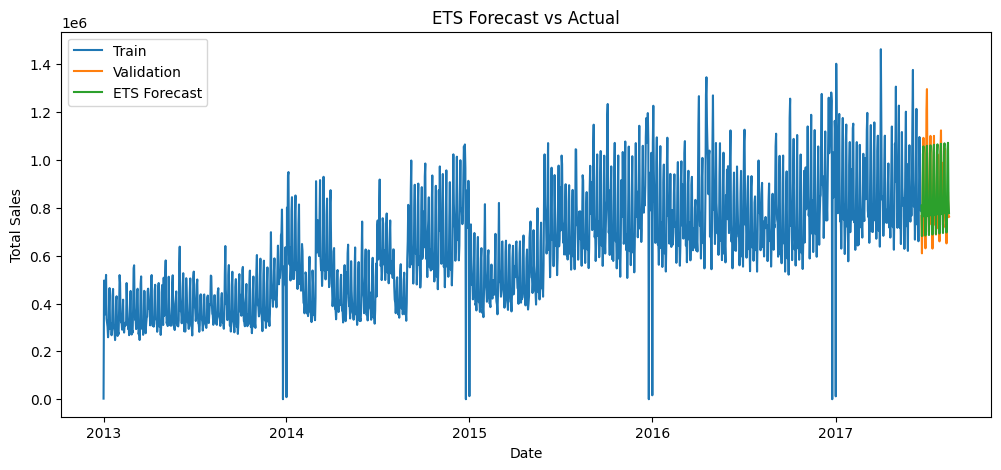

In [ ]:
# Plot Forecast vs Actual

plt.figure(figsize=(12,5))
plt.plot(train_ts.index, train_ts["sales"], label="Train")
plt.plot(val_ts.index, val_ts["sales"], label="Validation")
plt.plot(val_ts.index, ets_forecast, label="ETS Forecast")
plt.legend()
plt.title("ETS Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


In [ ]:
# Calculate RMSLE for ETS forecast

def rmsle(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

ets_rmsle = rmsle(val_ts["sales"], ets_forecast)
print("ETS Validation RMSLE:", ets_rmsle)


ETS Validation RMSLE: 0.0918353665432764


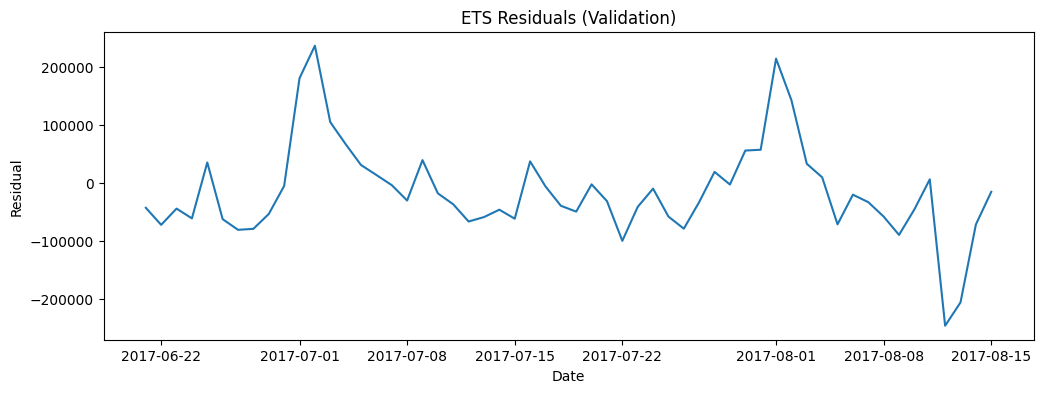

In [33]:
# Residuals for ETS on validation set
ets_resid = val_ts["sales"] - ets_forecast

plt.figure(figsize=(12,4))
plt.plot(ets_resid)
plt.title("ETS Residuals (Validation)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()


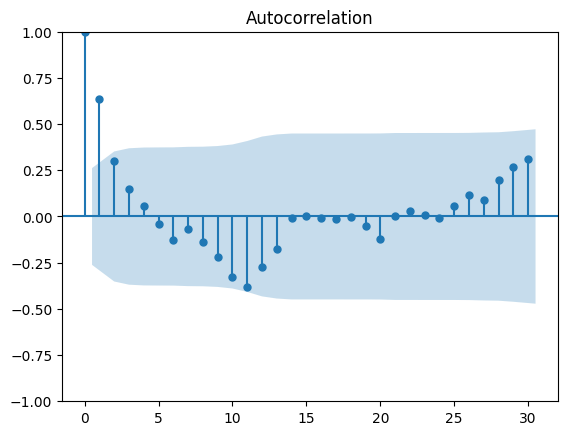

In [ ]:
# Residual autocorrelation check
plot_acf(ets_resid.dropna(), lags=30)
plt.show()


In [ ]:
# ADF test for stationarity (p-value > 0.05 means the series is not stationary)
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train_ts["sales"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -2.5011643716780108
p-value: 0.11519127754304559


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model with weekly seasonality
sarima_model = SARIMAX(
    train_ts["sales"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model.summary())


/Users/machome/mambaforge/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/machome/mambaforge/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/machome/mambaforge/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1632
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -21017.020
Date:                           Wed, 11 Feb 2026   AIC                          42044.040
Time:                                   19:43:28   BIC                          42070.975
Sample:                               01-01-2013   HQIC                         42054.037
                                    - 06-20-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3865      0.016     23.804      0.000       0.355       0.418
ma.L1         -0.9486      0.008   -112.555

In [37]:
# Forecast the validation window
sarima_forecast = sarima_model.forecast(len(val_ts))

# Quick look
sarima_forecast.head()


2017-06-21    8.234201e+05
2017-06-22    6.906937e+05
2017-06-23    8.268018e+05
2017-06-24    1.060254e+06
2017-06-25    1.047415e+06
Freq: D, Name: predicted_mean, dtype: float64

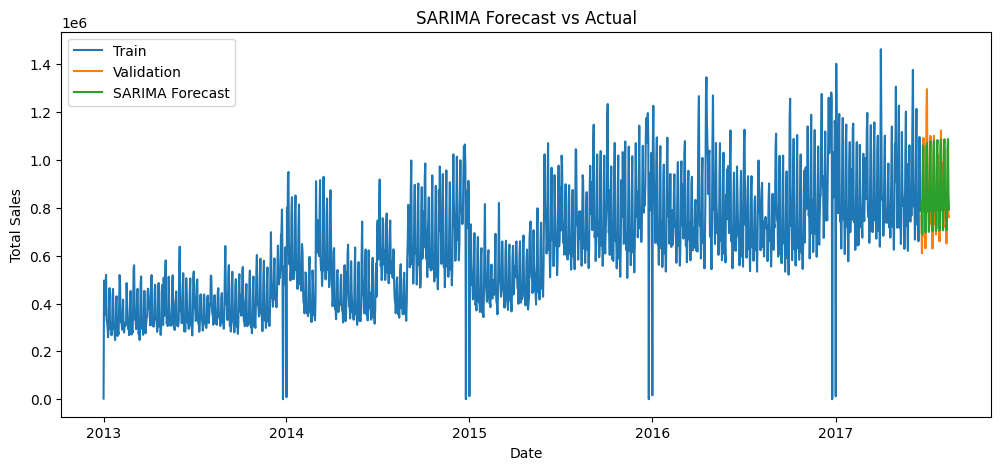

In [38]:
# Plot SARIMA forecast against training and validation data

plt.figure(figsize=(12,5))
plt.plot(train_ts.index, train_ts["sales"], label="Train")
plt.plot(val_ts.index, val_ts["sales"], label="Validation")
plt.plot(val_ts.index, sarima_forecast, label="SARIMA Forecast")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


In [39]:
# Compute validation RMSLE for SARIMA
sarima_rmsle = rmsle(val_ts["sales"], sarima_forecast)
print("SARIMA Validation RMSLE:", sarima_rmsle)


SARIMA Validation RMSLE: 0.09814105991699663


In [40]:
# Build full daily total sales series
daily_sales_full = (
    train.groupby("date")["sales"]
    .sum()
    .reset_index()
)

daily_sales_full["date"] = pd.to_datetime(daily_sales_full["date"])
daily_sales_full = daily_sales_full.set_index("date").sort_index()

# Get number of unique test dates to forecast
test_dates = pd.to_datetime(test["date"].unique())
horizon_test = len(test_dates)


In [ ]:
# Refit ETS on full data
ets_full = ExponentialSmoothing(
    daily_sales_full["sales"],
    trend="add",
    seasonal="add",
    seasonal_periods=7
).fit()

# Forecast test period
ets_test_forecast = ets_full.forecast(horizon_test)

# Map daily forecast to test rows
ets_pred_by_date = pd.DataFrame({
    "date": pd.to_datetime(test_dates),
    "sales": ets_test_forecast.values
})


test_with_dates = test.copy()
test_with_dates["date"] = pd.to_datetime(test_with_dates["date"])

submission_ets = test_with_dates.merge(ets_pred_by_date, on="date", how="left")
submission_ets = submission_ets[["id", "sales"]]

submission_ets.to_csv("submission_ets.csv", index=False)
print("Saved submission_ets.csv")


/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: divide by zero encountered in matmul
  return err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: invalid value encountered in matmul
  return err.T @ err


Saved submission_ets.csv


/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: divide by zero encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:1377: RuntimeWarning: invalid value encountered in matmul
  sse = err.T @ err
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

In [ ]:
# Refit SARIMA on full data
sarima_full = SARIMAX(
    daily_sales_full["sales"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast test period
sarima_test_forecast = sarima_full.forecast(horizon_test)

# Map daily forecast to test rows
sarima_pred_by_date = pd.DataFrame({
    "date": pd.to_datetime(test_dates),
    "sales": sarima_test_forecast.values
})


submission_sarima = test_with_dates.merge(sarima_pred_by_date, on="date", how="left")
submission_sarima = submission_sarima[["id", "sales"]]

submission_sarima.to_csv("submission_sarima.csv", index=False)
print("Saved submission_sarima.csv")


/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/machome/mambaforge/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/machome/mambaforge/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/machome/mambaforge/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  r

Saved submission_sarima.csv


/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/machome/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
